In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [2]:
import torch
import torchvision

from torchvision import transforms,datasets
from torch.utils.data import DataLoader
from torch import nn

import matplotlib.pyplot as plt
import numpy as np

try:
  import torchinfo
  from torchinfo import summary
  print("torchinfo is imported")
except:
  !pip install -q torchinfo
  import torchinfo
  from torchinfo import summary
try:
  from going_modular.going_modular import data_setup,engine
  from helper_functions import set_seeds,plot_loss_curves
except:
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup,engine
  from helper_functions import set_seeds,plot_loss_curves

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 4356 (delta 154), reused 120 (delta 120), pack-reused 4171 (from 3)
Receiving objects: 100% (4356/4356), 654.37 MiB | 38.40 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


In [3]:
import os
import zipfile
from pathlib import Path
import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:

    data_path = Path("data/")
    image_path = data_path / destination

    if not image_path.exists():
        print(f"[INFO] Did not find {image_path}, creating it...")
        image_path.mkdir(parents=True, exist_ok=True)

    target_file = Path(source).name
    zip_file_path = data_path / target_file

    if zip_file_path.exists():
        print(f"[INFO] {zip_file_path} already exists, skipping download.")
    else:
        try:
            print(f"[INFO] Downloading {target_file} from {source}...")
            response = requests.get(source)
            response.raise_for_status()

            with open(zip_file_path, "wb") as file:
                file.write(response.content)

            print(f"[INFO] Downloaded {target_file} successfully.")

        except requests.exceptions.RequestException as e:
            print(f"[ERROR] Failed to download the file: {e}")
            return None


    try:
        if zip_file_path.suffix == ".zip":
            print(f"[INFO] Unzipping {target_file}...")
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(image_path)
            print(f"[INFO] Unzipped data to {image_path}.")
        else:
            print("[ERROR] The downloaded file is not a valid zip file.")
            return None


        if remove_source:
            os.remove(zip_file_path)
            print(f"[INFO] Removed the zip file: {zip_file_path}")

    except zipfile.BadZipFile as e:
        print(f"[ERROR] Failed to unzip the file: {e}")
        return None

    return image_path

image_path = download_data(source="https://github.com/Shaheed-colab/Data/raw/refs/heads/main/DATASET_2.zip",
                           destination="DATASET_2")

if image_path:
    print(f"Data has been extracted to: {image_path}")
else:
    print("An error occurred during the download or extraction process.")

[INFO] Did not find data/DATASET_2, creating it...
[INFO] Downloading DATASET_2.zip from https://github.com/Shaheed-colab/Data/raw/refs/heads/main/DATASET_2.zip...
[INFO] Downloaded DATASET_2.zip successfully.
[INFO] Unzipping DATASET_2.zip...
[INFO] Unzipped data to data/DATASET_2.
[INFO] Removed the zip file: data/DATASET_2.zip
Data has been extracted to: data/DATASET_2


In [4]:
train_dir = image_path / "DATASET_2" / "train"
test_dir = image_path / "DATASET_2" / "test"

In [5]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()  # Remove the parentheses here
])

In [7]:
BATCH_SIZE = 32

train_dataloader,test_dataloader,class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

In [8]:
image_batch,label_batch = next(iter(train_dataloader))
image,label = image_batch[0],label_batch[0]
image.shape,label

(torch.Size([3, 224, 224]), tensor(2))

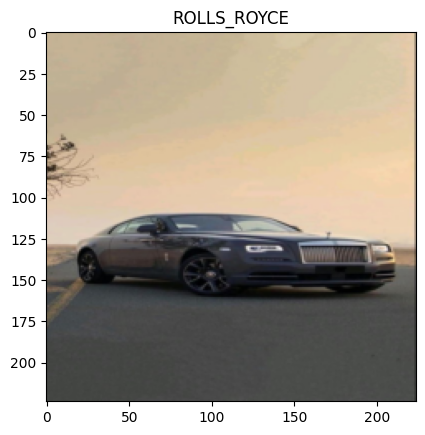

In [9]:
image_permute = image.permute(1,2,0)
plt.imshow(image_permute)
plt.title(class_names[label])
plt.axis()
plt.show()

In [10]:
height = 224
width = 224
patch_size = 16
color_channels = 3

number_of_patches = (height * width) / (patch_size ** 2)
print(f"Number of patches: {number_of_patches}")

Number of patches: 196.0


In [11]:
embedded_image_input_shape = (height,width,color_channels)
embedded_image_output_shape = (number_of_patches,patch_size ** 2 * color_channels)
print(f"Embedded image input shape: {embedded_image_input_shape}")
print(f"Embedded image output shape: {embedded_image_output_shape}")

Embedded image input shape: (224, 224, 3)
Embedded image output shape: (196.0, 768)


(-0.5, 223.5, 223.5, -0.5)

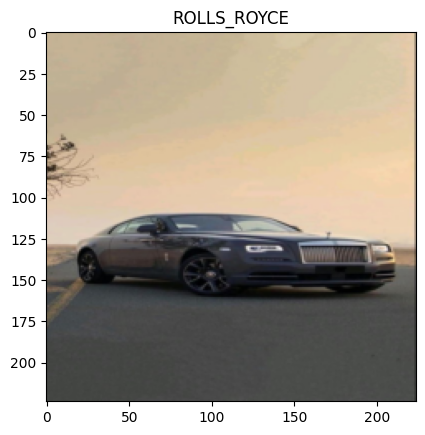

In [12]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis()

(-0.5, 223.5, 15.5, -0.5)

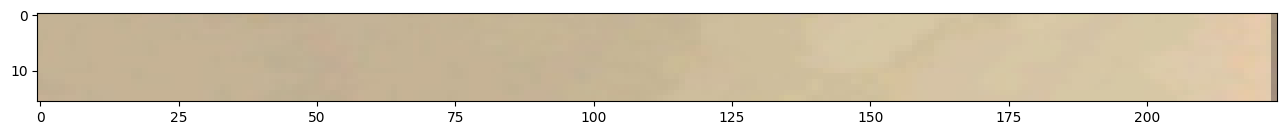

In [13]:
image_permuted = image.permute(1,2,0)
patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:])
plt.axis()

number of patches14.0


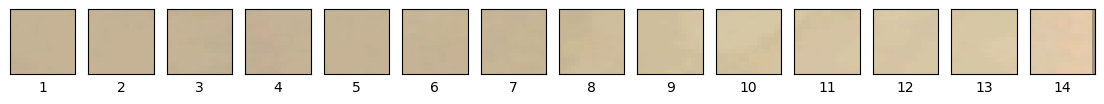

In [14]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0
print(f"number of patches{num_patches}")

fig,axs = plt.subplots(nrows=1,
                       ncols=img_size // patch_size,
                       figsize=(num_patches,num_patches),
                       sharex=True,
                       sharey=True)

for i,patch in enumerate(range(0,img_size,patch_size)):
  axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


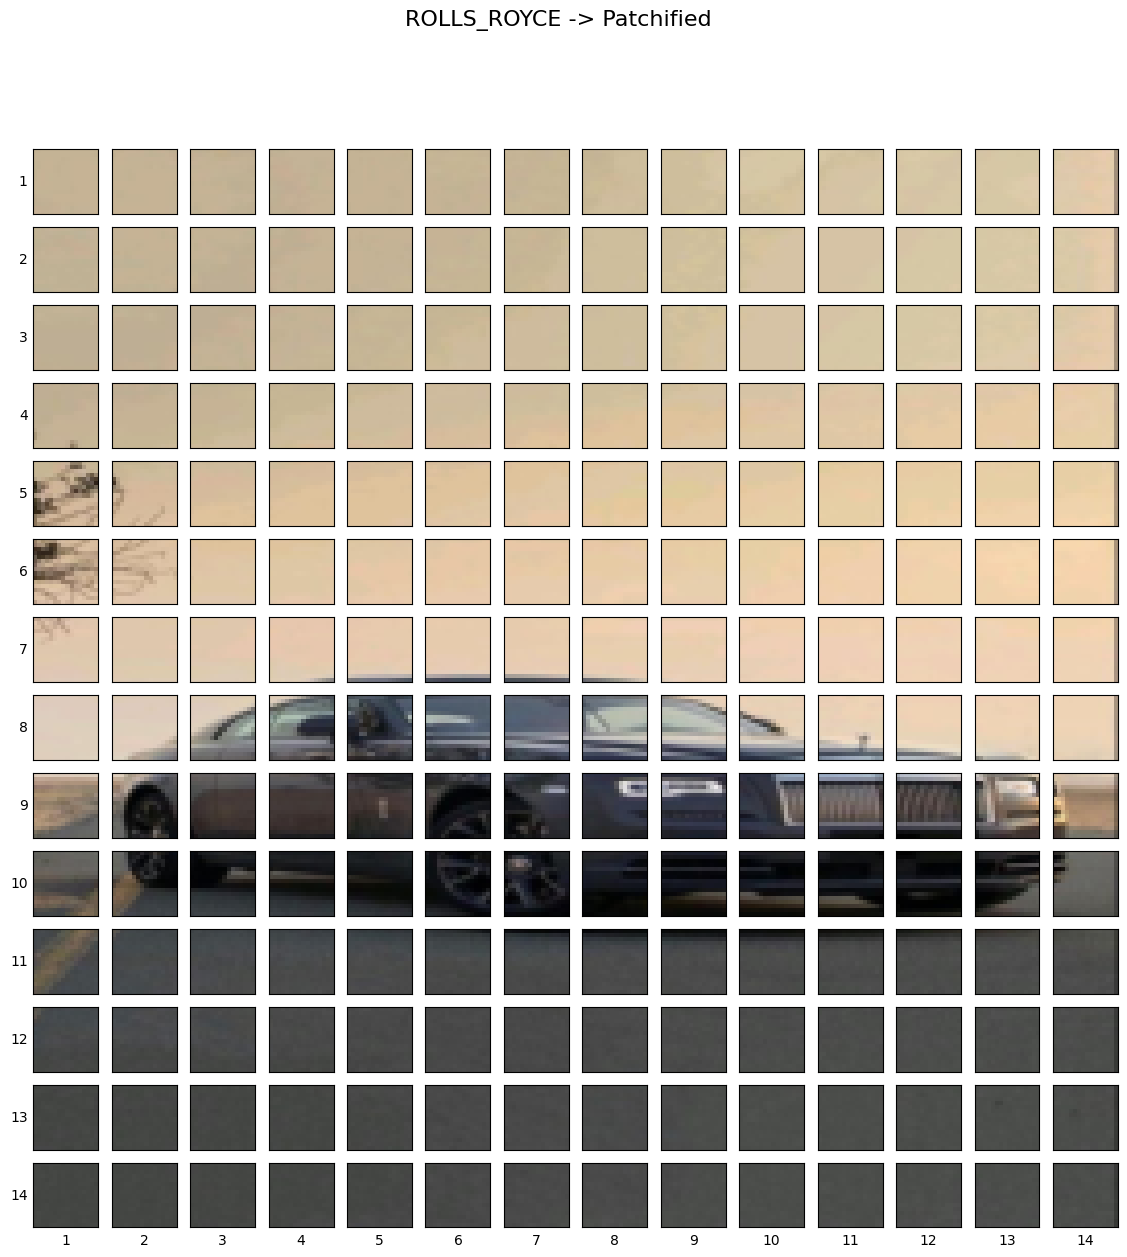

In [15]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)


for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):

        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                        patch_width:patch_width+patch_size,
                                        :])

        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [16]:
random_image_tensor = torch.randn(1,3,224,224)
random_image_tensor.shape

torch.Size([1, 3, 224, 224])

In [17]:
import torch.nn as nn
class PatchEmbedding(nn.Module):

  def __init__(self,
               in_channels:int=3,
               embedding_dim:int=768,
               patch_size:int=16):

    super().__init__()

    self.patch_size = patch_size

    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels = embedding_dim,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding = 0)

    self.flatten = nn.Flatten(start_dim = 2,
                              end_dim = 3)

  def forward(self,x):
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0 ,f"number of image_resolution in embedded_dim {image_resolution} patchsize {patch_size}"
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0,2,1)

In [18]:
patch_embedding = PatchEmbedding(patch_size = 16)
patch_embedding_output = patch_embedding(random_image_tensor)

print(patch_embedding_output.shape)

torch.Size([1, 196, 768])


In [19]:
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                       nhead=12,
                                                       dim_feedforward=3072,
                                                       dropout=0.1,
                                                       activation='gelu',
                                                       batch_first=True,
                                                       norm_first=True)

In [20]:
summary(model=transformer_encoder_layer)

Layer (type:depth-idx)                             Param #
TransformerEncoderLayer                            --
├─MultiheadAttention: 1-1                          1,771,776
│    └─NonDynamicallyQuantizableLinear: 2-1        590,592
├─Linear: 1-2                                      2,362,368
├─Dropout: 1-3                                     --
├─Linear: 1-4                                      2,360,064
├─LayerNorm: 1-5                                   1,536
├─LayerNorm: 1-6                                   1,536
├─Dropout: 1-7                                     --
├─Dropout: 1-8                                     --
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0

In [21]:
transformer_encoder = nn.TransformerEncoder(encoder_layer=transformer_encoder_layer,
                                            num_layers=12)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [22]:
summary(model = transformer_encoder)

Layer (type:depth-idx)                                       Param #
TransformerEncoder                                           --
├─ModuleList: 1-1                                            --
│    └─TransformerEncoderLayer: 2-1                          --
│    │    └─MultiheadAttention: 3-1                          2,362,368
│    │    └─Linear: 3-2                                      2,362,368
│    │    └─Dropout: 3-3                                     --
│    │    └─Linear: 3-4                                      2,360,064
│    │    └─LayerNorm: 3-5                                   1,536
│    │    └─LayerNorm: 3-6                                   1,536
│    │    └─Dropout: 3-7                                     --
│    │    └─Dropout: 3-8                                     --
│    └─TransformerEncoderLayer: 2-2                          --
│    │    └─MultiheadAttention: 3-9                          2,362,368
│    │    └─Linear: 3-10                                     2,36

In [23]:
class ViT(nn.Module):

  def __init__(self,
               img_size = 224,
               num_channels = 3,
               patch_size = 16,
               embedding_dim = 768,
               dropout = 0.1,
               mlp_size = 3072,
               num_transformer_layer = 3072,
               num_heads = 12,
               num_classes = 1000):

    super().__init__()

    assert img_size % patch_size == 0

    num_patches = (img_size // patch_size) ** 2

    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          embedding_dim=embedding_dim,
                                          patch_size=patch_size)

    self.class_token = nn.Parameter(torch.randn(1,1,embedding_dim),
                                    requires_grad=True)

    self.positional_embedding = nn.Parameter(torch.randn(1,num_patches+1,embedding_dim))

    self.embedding_dropout = nn.Dropout(p=dropout)

    self.transformer_encoder = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                       nhead=num_heads,
                                                       dim_feedforward=mlp_size,
                                                       activation='gelu',
                                                       batch_first=True,
                                                       norm_first=True)

    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes)
    )

  def forward(self,x):

    batch_size = x.shape[0]

    x = self.patch_embedding(x)

    class_token = self.class_token.expand(batch_size,-1,-1)

    x = torch.cat((class_token,x),dim=1)

    x = self.positional_embedding + x

    x = self.embedding_dropout(x)

    x = self.transformer_encoder(x)

    x = self.mlp_head(x[:,0])

    return x

In [24]:
demo_img = torch.randn(1,3,224,224).to(device)
vit = ViT(num_classes=len(class_names)).to(device) # Move the model to the device
vit(demo_img)

tensor([[ 1.3820,  0.2928, -0.8076]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [25]:
summary(model = vit)

Layer (type:depth-idx)                                  Param #
ViT                                                     152,064
├─PatchEmbedding: 1-1                                   --
│    └─Conv2d: 2-1                                      590,592
│    └─Flatten: 2-2                                     --
├─Dropout: 1-2                                          --
├─TransformerEncoderLayer: 1-3                          --
│    └─MultiheadAttention: 2-3                          1,771,776
│    │    └─NonDynamicallyQuantizableLinear: 3-1        590,592
│    └─Linear: 2-4                                      2,362,368
│    └─Dropout: 2-5                                     --
│    └─Linear: 2-6                                      2,360,064
│    └─LayerNorm: 2-7                                   1,536
│    └─LayerNorm: 2-8                                   1,536
│    └─Dropout: 2-9                                     --
│    └─Dropout: 2-10                                    --
├─Sequent

In [26]:
len(class_names)

3

In [27]:
%%writefile vit.py
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):

  def __init__(self,
               in_channels:int=3,
               embedding_dim:int=768,
               patch_size:int=16):

    super().__init__()

    self.patch_size = patch_size

    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels = embedding_dim,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding = 0)

    self.flatten = nn.Flatten(start_dim = 2,
                              end_dim = 3)

  def forward(self,x):
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0 ,f"number of image_resolution in embedded_dim {image_resolution} patchsize {patch_size}"
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0,2,1)

class ViT(nn.Module):

  def __init__(self,
               img_size = 224,
               num_channels = 3,
               patch_size = 16,
               embedding_dim = 768,
               dropout = 0.1,
               mlp_size = 3072,
               num_transformer_layer = 3072,
               num_heads = 12,
               num_classes = 1000):

    super().__init__()

    assert img_size % patch_size == 0

    num_patches = (img_size // patch_size) ** 2

    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          embedding_dim=embedding_dim,
                                          patch_size=patch_size)

    self.class_token = nn.Parameter(torch.randn(1,1,embedding_dim),
                                    requires_grad=True)

    self.positional_embedding = nn.Parameter(torch.randn(1,num_patches+1,embedding_dim))

    self.embedding_dropout = nn.Dropout(p=dropout)

    self.transformer_encoder = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                       nhead=num_heads,
                                                       dim_feedforward=mlp_size,
                                                       activation='gelu',
                                                       batch_first=True,
                                                       norm_first=True)

    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes)
    )

  def forward(self,x):

    batch_size = x.shape[0]

    x = self.patch_embedding(x)

    class_token = self.class_token.expand(batch_size,-1,-1)

    x = torch.cat((class_token,x),dim=1)

    x = self.positional_embedding + x

    x = self.embedding_dropout(x)

    x = self.transformer_encoder(x)

    x = self.mlp_head(x[:,0])

    return x

Writing vit.py


In [28]:
from vit import ViT

imported_vit = ViT()
summary(model=imported_vit,
        input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ViT                                      [1, 1000]                 152,064
├─PatchEmbedding: 1-1                    [1, 196, 768]             --
│    └─Conv2d: 2-1                       [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                      [1, 768, 196]             --
├─Dropout: 1-2                           [1, 197, 768]             --
├─TransformerEncoderLayer: 1-3           [1, 197, 768]             --
│    └─LayerNorm: 2-3                    [1, 197, 768]             1,536
│    └─MultiheadAttention: 2-4           [1, 197, 768]             2,362,368
│    └─Dropout: 2-5                      [1, 197, 768]             --
│    └─LayerNorm: 2-6                    [1, 197, 768]             1,536
│    └─Linear: 2-7                       [1, 197, 3072]            2,362,368
│    └─Dropout: 2-8                      [1, 197, 3072]            --
│    └─Linear: 2-9                       [1, 197, 768] 

In [29]:
import torchvision

weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_model = torchvision.models.vit_b_16(weights = weights)

for params in pretrained_model.parameters():
  params.requires_grad=False

embedding_dim = 768

set_seeds()

pretrained_model.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape = embedding_dim),
    nn.Linear(in_features = embedding_dim,
              out_features = len(class_names))
)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 86.2MB/s]


In [30]:
summary(model = pretrained_model)

Layer (type:depth-idx)                                            Param #
VisionTransformer                                                 768
├─Conv2d: 1-1                                                     (590,592)
├─Encoder: 1-2                                                    151,296
│    └─Dropout: 2-1                                               --
│    └─Sequential: 2-2                                            --
│    │    └─EncoderBlock: 3-1                                     (7,087,872)
│    │    └─EncoderBlock: 3-2                                     (7,087,872)
│    │    └─EncoderBlock: 3-3                                     (7,087,872)
│    │    └─EncoderBlock: 3-4                                     (7,087,872)
│    │    └─EncoderBlock: 3-5                                     (7,087,872)
│    │    └─EncoderBlock: 3-6                                     (7,087,872)
│    │    └─EncoderBlock: 3-7                                     (7,087,872)
│    │    └─EncoderBlo

In [31]:
len(train_dataloader),len(test_dataloader),len(class_names)

(3, 2, 3)

In [32]:
from going_modular.going_modular import engine

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = pretrained_model.parameters(),
                             lr = 0.001)

pretrained_model_results = engine.train(model = pretrained_model,
                                        train_dataloader = train_dataloader,
                                        test_dataloader = test_dataloader,
                                        loss_fn = loss_fn,
                                        optimizer = optimizer,
                                        epochs = 10,
                                        device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2151 | train_acc: 0.3958 | test_loss: 0.9889 | test_acc: 0.5357
Epoch: 2 | train_loss: 0.9412 | train_acc: 0.5929 | test_loss: 0.8843 | test_acc: 0.5513
Epoch: 3 | train_loss: 0.7530 | train_acc: 0.7252 | test_loss: 0.8065 | test_acc: 0.6004
Epoch: 4 | train_loss: 0.6302 | train_acc: 0.7772 | test_loss: 0.7245 | test_acc: 0.6696
Epoch: 5 | train_loss: 0.5379 | train_acc: 0.9119 | test_loss: 0.6747 | test_acc: 0.6875
Epoch: 6 | train_loss: 0.4695 | train_acc: 0.8734 | test_loss: 0.6352 | test_acc: 0.6897
Epoch: 7 | train_loss: 0.4100 | train_acc: 0.9143 | test_loss: 0.6145 | test_acc: 0.7031
Epoch: 8 | train_loss: 0.3605 | train_acc: 0.9375 | test_loss: 0.5974 | test_acc: 0.7210
Epoch: 9 | train_loss: 0.3268 | train_acc: 0.9639 | test_loss: 0.5897 | test_acc: 0.7054
Epoch: 10 | train_loss: 0.2938 | train_acc: 0.9792 | test_loss: 0.5741 | test_acc: 0.7054


In [41]:
pretrained_weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
pretrained_transforms = pretrained_weights.transforms()
pretrained_vit_model = torchvision.models.vit_b_16(weights = pretrained_weights)

for params in pretrained_vit_model.parameters():
  params.requires_grad = False

embedding_dim = 768

set_seeds()

pretrained_vit_model.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape = embedding_dim),
    nn.Linear(in_features = embedding_dim,
              out_features = len(class_names))
)

In [42]:
train_dataloader_vit,test_dataloader_vit,class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = pretrained_transforms,
    batch_size = 32
)

In [43]:
summary(model = pretrained_vit_model)

Layer (type:depth-idx)                                            Param #
VisionTransformer                                                 768
├─Conv2d: 1-1                                                     (590,592)
├─Encoder: 1-2                                                    443,136
│    └─Dropout: 2-1                                               --
│    └─Sequential: 2-2                                            --
│    │    └─EncoderBlock: 3-1                                     (7,087,872)
│    │    └─EncoderBlock: 3-2                                     (7,087,872)
│    │    └─EncoderBlock: 3-3                                     (7,087,872)
│    │    └─EncoderBlock: 3-4                                     (7,087,872)
│    │    └─EncoderBlock: 3-5                                     (7,087,872)
│    │    └─EncoderBlock: 3-6                                     (7,087,872)
│    │    └─EncoderBlock: 3-7                                     (7,087,872)
│    │    └─EncoderBlo

In [44]:
from going_modular.going_modular import engine

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = pretrained_vit_model.parameters(),
                             lr = 0.001)

pretrained_vit_model_results = engine.train(model = pretrained_vit_model,
                                            train_dataloader = train_dataloader_vit,
                                            test_dataloader = test_dataloader_vit,
                                            loss_fn = loss_fn,
                                            optimizer = optimizer,
                                            epochs = 10,
                                            device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1084 | train_acc: 0.4607 | test_loss: 0.8312 | test_acc: 0.7768
Epoch: 2 | train_loss: 0.7243 | train_acc: 0.7171 | test_loss: 0.6127 | test_acc: 0.8638
Epoch: 3 | train_loss: 0.5300 | train_acc: 0.8910 | test_loss: 0.4882 | test_acc: 0.8638
Epoch: 4 | train_loss: 0.4065 | train_acc: 0.9271 | test_loss: 0.4035 | test_acc: 0.9196
Epoch: 5 | train_loss: 0.3257 | train_acc: 0.9223 | test_loss: 0.3507 | test_acc: 0.9174
Epoch: 6 | train_loss: 0.2762 | train_acc: 0.9247 | test_loss: 0.3155 | test_acc: 0.9509
Epoch: 7 | train_loss: 0.2393 | train_acc: 0.9431 | test_loss: 0.2847 | test_acc: 0.9330
Epoch: 8 | train_loss: 0.2125 | train_acc: 0.9583 | test_loss: 0.2619 | test_acc: 0.9509
Epoch: 9 | train_loss: 0.1955 | train_acc: 0.9559 | test_loss: 0.2451 | test_acc: 0.9509
Epoch: 10 | train_loss: 0.1701 | train_acc: 0.9688 | test_loss: 0.2301 | test_acc: 0.9688


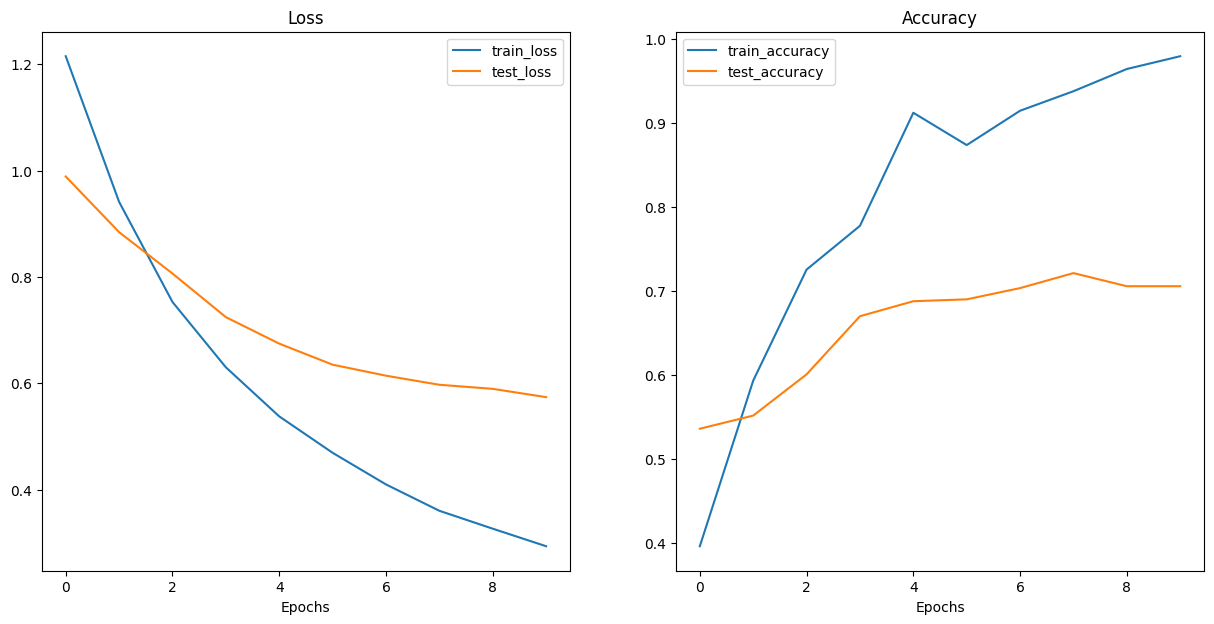

In [45]:
plot_loss_curves(pretrained_model_results)

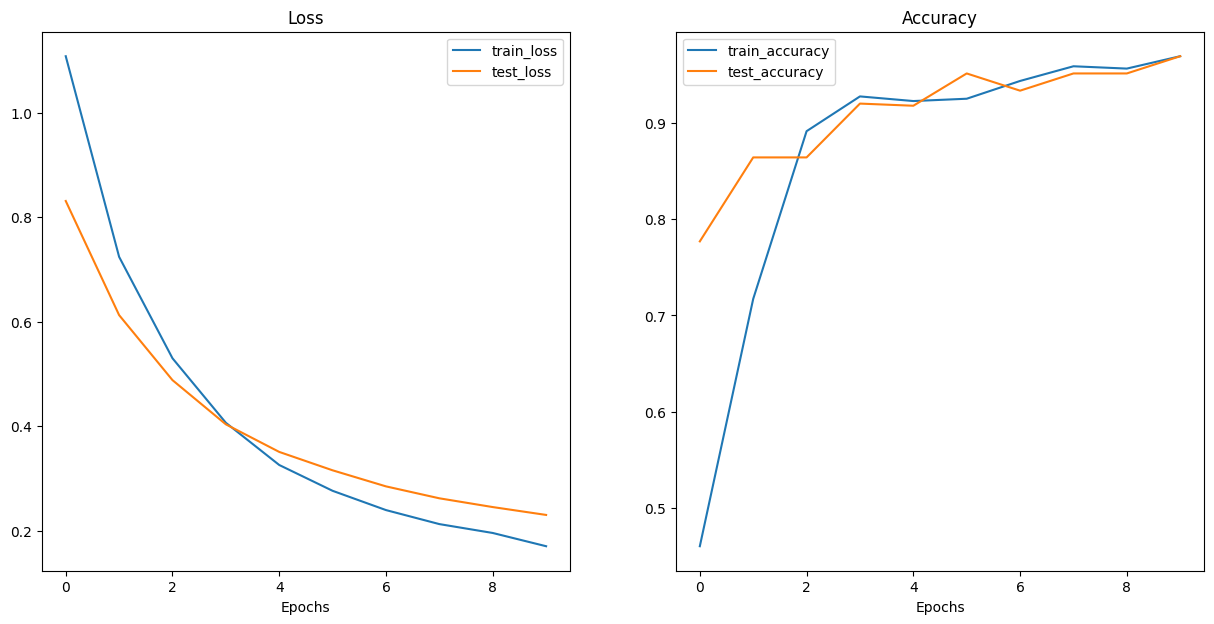

In [46]:
plot_loss_curves(pretrained_vit_model_results)

In [47]:
from going_modular.going_modular import utils

utils.save_model(model = pretrained_vit_model,
                 target_dir = "models",
                 model_name = "paper_replicating_DATASET_2.pth")

[INFO] Saving model to: models/paper_replicating_DATASET_2.pth


In [48]:
from pathlib import Path

model_path = Path("models/paper_replicating_DATASET_2.pth").stat().st_size // (1024*1024)
print(model_path)

328


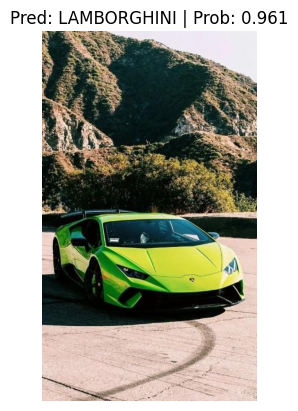

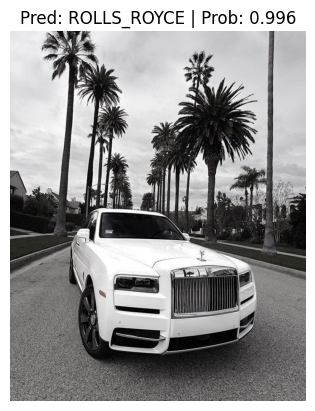

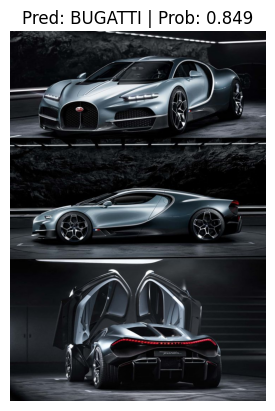

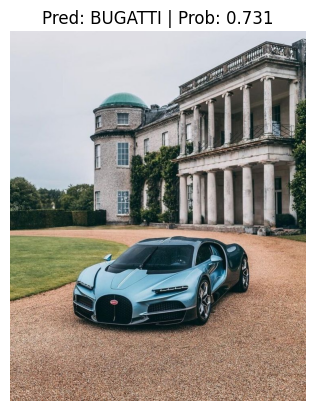

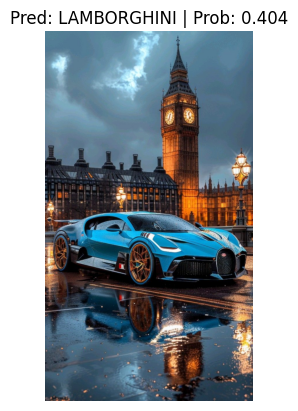

In [58]:
from going_modular.going_modular.predictions import pred_and_plot_image
import random

num_image_plots = 5
test_image_path_list = list(test_dir.glob("*/*.jpg"))
test_image_sample_path = random.sample(population = test_image_path_list,k=num_image_plots)

for image_path in test_image_sample_path:
  pred_and_plot_image(model = pretrained_vit_model,
                      image_path = image_path,
                      class_names = class_names,
                      image_size = (384,384))

ROLLS ROYCE CULLINAN BLACK BADGE 6_7P AT MY2023.jpg already exists and is valid.
ROLLS ROYCE CULLINAN BLACK BADGE 6_7P AT MY2023.jpg is a valid image.


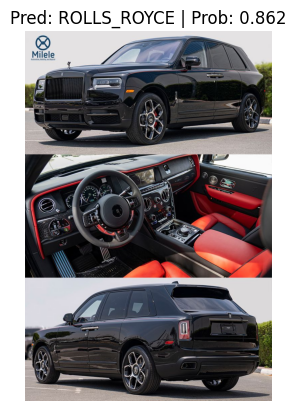

In [61]:
import requests
from pathlib import Path
from PIL import Image
from going_modular.going_modular.predictions import pred_and_plot_image

url = "https://raw.githubusercontent.com/Shaheed-colab/Data/refs/heads/main/ROLLS%20ROYCE%20CULLINAN%20BLACK%20BADGE%206_7P%20AT%20MY2023.jpg"
custom_image = Path("ROLLS ROYCE CULLINAN BLACK BADGE 6_7P AT MY2023.jpg")


if custom_image.is_file():
    try:

        Image.open(custom_image).verify()
        print(f"{custom_image.name} already exists and is valid.")
    except Exception:
        print(f"{custom_image.name} is invalid. Re-downloading...")
        custom_image.unlink()


if not custom_image.is_file():
    with open(custom_image, "wb") as f:
        response = requests.get(url)
        if response.status_code == 200:
            print(f"Downloading {custom_image.name}...")
            f.write(response.content)
            print(f"{custom_image.name} downloaded successfully.")
        else:
            print(f"Failed to download the file. Status code: {response.status_code}")


try:
    img = Image.open(custom_image)
    img.verify()
    print(f"{custom_image.name} is a valid image.")
except Exception as e:
    print(f"Error: {e}. The downloaded file is not a valid image.")
    raise


pred_and_plot_image(model=pretrained_vit_model, image_path=custom_image, class_names=class_names, image_size = (384,384))